<u>Dominik Mattioli code for Problem 2 of the Questionnaire Interview.</u>

Dear reviewing team,

The following jupyter notebook contains detailed and commented code blocks and markdown blocks explaining my approach to a problem I recently attempted. There is a publically available [dataset](https://questionnaire-148920.appspot.com/qas/obp.csv) showing the on-base percentage (OBP), plate appearnaces (PA), and player name for a set of baseball players for the 2016-2021 seasons. The task was to predict each player's OBP for the 2021 season given his PA and OBP from 2016-2020.

I have numbered the sections of my assignment and made the corresponding markdown text larger for your convenience. Nonetheless, it is a length notebook. Please feel free to skip all the way to the bottom to see my 5 paragraph writeup detailing my methodology and my results.

Thank you very much for this opportunity!

Sincerely,

_Dominik Mattioli_

In [4]:
# Assuming it is downloaded to the working folder.
import os
import pandas as pd
import numpy as np
from datetime import datetime

# from sklearn.linear_model import LinearRegression
# import pymc3 as pm
import bambi as bmb
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns
import warnings # Supresses warnings because I am a loose cannon.
pd.options.mode.chained_assignment = None 
warnings.simplefilter(action='ignore', category=FutureWarning)


fn = 'obp.csv'
data_raw = pd.read_csv( fn )

print( data_raw.head() )
print( 'Number of players in dataset: ' + str( len( data_raw ) ) )

              Name  playerid  birth_date  PA_21  OBP_21  PA_20  OBP_20  PA_19   
0  Trayce Thompson      9952  1991-03-15     35   0.400    NaN     NaN    NaN  \
1       Mike Trout     10155  1991-08-07    146   0.466  241.0   0.390  600.0   
2     Bryce Harper     11579  1992-10-16    599   0.429  244.0   0.420  682.0   
3     Chris Owings     10030  1991-08-12     50   0.420   44.0   0.318  196.0   
4      Nick Fortes     21538  1996-11-11     34   0.353    NaN     NaN    NaN   

   OBP_19  PA_18  OBP_18  PA_17  OBP_17  PA_16  OBP_16  
0     NaN  137.0   0.162   55.0   0.218  262.0   0.302  
1   0.438  608.0   0.460  507.0   0.442  681.0   0.441  
2   0.372  695.0   0.393  492.0   0.413  627.0   0.373  
3   0.209  309.0   0.272  386.0   0.299  466.0   0.315  
4     NaN    NaN     NaN    NaN     NaN    NaN     NaN  
Number of players in dataset: 572


## 0. Preprocessing the Data
- Redundant and incomplete data: Scan for duplicate playerid and names, remove from the dataset.
    - Nan's will be dealt with (ignored by model) later.
- Add some derivable columns, i.e., Age, Number of times reached base (NTRB)


In [5]:
# Remove duplicate rows.
data_raw.drop_duplicates( subset=['Name', 'playerid'], keep='first', inplace=True )

# Calculate player's age (let's use decimal ages), append to data
def calculate_age( birthdate, startdate ):
    age_in_days = ( startdate - birthdate ).days
    age_in_years = age_in_days / 365.25
    return round( age_in_years, 1 )

startdates = { '16': '2016-04-03', '17': '2017-04-02',
                    '18': '2018-03-29', '19': '2019-03-20',
                    '20': '2020-07-23',  '21': '2021-04-01' }
startdate_dt = {key: datetime.strptime(value, '%Y-%m-%d') for key, value in startdates.items()}

data = data_raw.copy()
for key, value in startdate_dt.items():
    data[f'Age_{key}'] = data['birth_date'].apply(lambda x: round( (value - datetime.strptime(x, '%Y-%m-%d')).days / 365, 1 ) )

print( 'Sample tests of preprocessing:')
print( data.loc[0]['birth_date'], '-- Age at start of 2016 season (', startdates['16'], '): ', data.loc[0]['Age_16'] )
print( data.loc[data.index.max()]['birth_date'], '-- Age at start of 2021 season (', startdates['21'], '): ', data.loc[data.index.max()]['Age_21'] )

# Calculate the number of times each player reached base each season, append as a column.
for year, v in startdates.items():
    data[f'NTRB_{year}'] = data[f'PA_{year}'] * data[f'OBP_{year}']

Sample tests of preprocessing:
1991-03-15 -- Age at start of 2016 season ( 2016-04-03 ):  25.1
1983-08-09 -- Age at start of 2021 season ( 2021-04-01 ):  37.7


#### Let's look at the data:

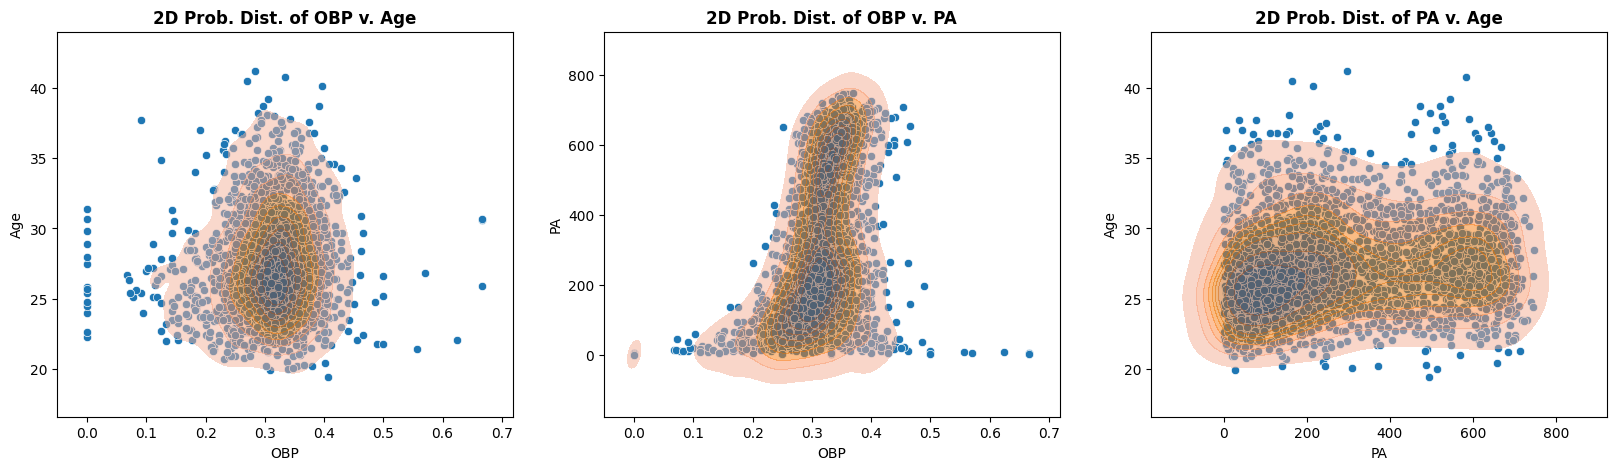

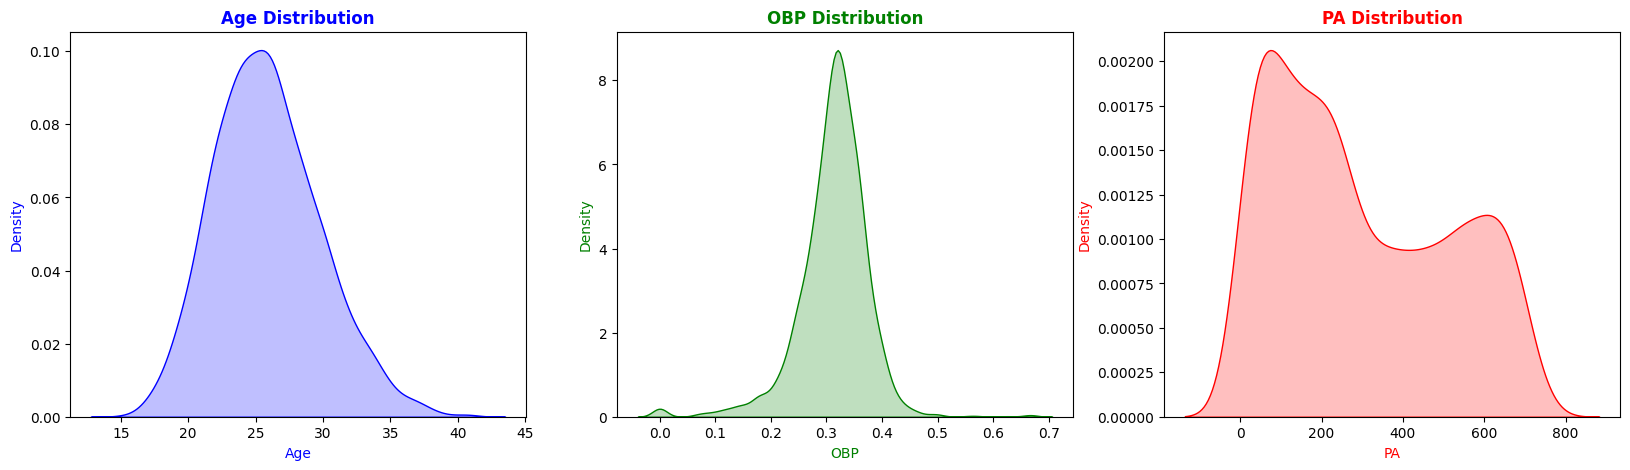

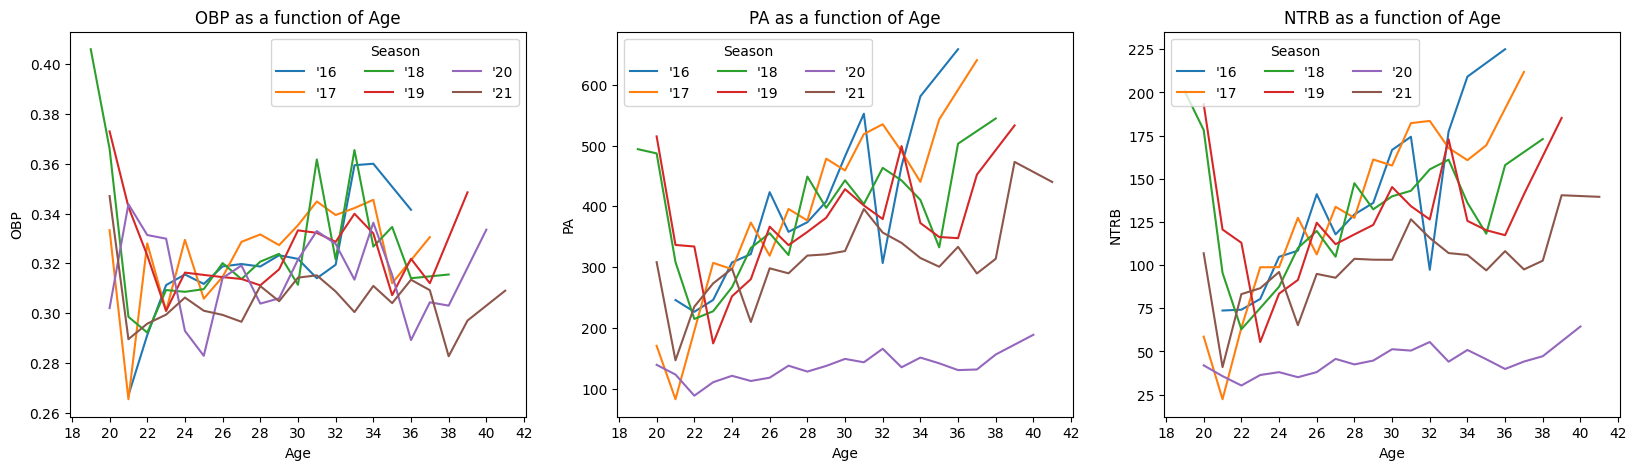

In [6]:
df_sample = pd.DataFrame( { 'Age':[], 'OBP':[], 'PA':[] } )
for year in range(16,22):
    td_tmp = pd.DataFrame( { 'Age': data['Age_'+str( year )], 'OBP': data['OBP_'+str(year)], 'PA': data['PA_'+str(year)] } )
    df_sample = pd.concat( [df_sample, td_tmp], axis=0 )
df_sample = df_sample.reset_index(drop=True)

fig, (ax1, ax2, ax3) = plt.subplots( nrows=1, ncols=3, figsize=(20, 5) )

# Overlay plots of the scatterplot probability density distribution for OBP v Age
sns.scatterplot( data=df_sample, x='OBP', y='Age', ax=ax1 )
sns.kdeplot( data=df_sample, x='OBP', y='Age', shade=True, alpha=0.5, ax=ax1, fill=True )
ax1.set_title( '2D Prob. Dist. of OBP v. Age', fontweight='bold' )
ax1.set_xlabel( 'OBP' )
ax1.set_ylabel( 'Age' )

# Overlay plots of the scatterplot probability density distribution for PA v Age
sns.scatterplot( data=df_sample, x='OBP', y='PA', ax=ax2 )
sns.kdeplot( data=df_sample, x='OBP', y='PA', shade=True, alpha=0.5, ax=ax2, fill=True )
ax2.set_title( '2D Prob. Dist. of OBP v. PA', fontweight='bold' )
ax2.set_xlabel( 'OBP' )
ax2.set_ylabel( 'PA' )

# Overlay plots of the scatterplot probability density distribution for PA v Age
sns.scatterplot( data=df_sample, x='PA', y='Age', ax=ax3 )
sns.kdeplot( data=df_sample, x='PA', y='Age', shade=True, alpha=0.5, ax=ax3, fill=True )
ax3.set_title( '2D Prob. Dist. of PA v. Age', fontweight='bold' )
ax3.set_xlabel( 'PA' )
ax3.set_ylabel( 'Age' )
plt.show()

# Plot each of the three variables' probability density functions
fig, (ax4, ax5, ax6) = plt.subplots( nrows=1, ncols=3, figsize=(20, 5) )
sns.kdeplot( data=df_sample['Age'], ax=ax4, color='blue', label='Age', fill=True )
sns.kdeplot( data=df_sample, x='OBP', ax=ax5, color='green', label='OBP', fill=True )
sns.kdeplot( data=df_sample, x='PA', ax=ax6, color='red', label='OBP', fill=True )
ax4.set_title( 'Age Distribution', color='blue', fontweight='bold' )
ax4.set_xlabel( 'Age', color='blue' )
ax4.set_ylabel( 'Density', color='blue' )
ax5.set_title( 'OBP Distribution', color='green', fontweight='bold' )
ax5.set_xlabel( 'OBP', color='green' )
ax5.set_ylabel( 'Density', color='green' )
ax6.set_title( 'PA Distribution', color='red', fontweight='bold' )
ax6.set_xlabel( 'PA', color='red' )
ax6.set_ylabel( 'Density', color='red' )
plt.show()

# compute means for each age and season, plot as series
fig, axs = plt.subplots( nrows=1, ncols=3, figsize=(20,5) )
seasons = ['16', '17', '18', '19', '20', '21'] #hard-coded, sorry.
season_means = {}
metrics = ['OBP', 'PA', 'NTRB']

for i, metric in enumerate(metrics):
    season_means = {}
    for season in seasons:
        season_data = data[['Age_' + season, metric + '_' + season]]
        season_data = season_data.replace( 0, np.nan )
        season_data = season_data.dropna()
        season_data['Age_' + season] = season_data['Age_' + season].round(0).astype(int)
        season_data = season_data.groupby('Age_' + season)[metric + '_' + season].mean()
        season_means[season] = season_data
        season_data.plot( ax=axs[i], label="'"+season )

    axs[i].legend( title='Season', loc='best', ncol=len( seasons )/2, )
    axs[i].set_title( metric + ' as a function of Age' )
    axs[i].set_xlabel( 'Age' )
    axs[i].set_ylabel( metric )
    axs[i].set_xticks( range( int( min( season_data.index ) -2 ), int( max( season_data.index ) ) + 2, 2 ) )
    axs[i].set_ylabel( metric ) 
plt.show()

## 0.1: Observations from plots after initial pre-procesing
- Age
    - Looks fine -- the density estimation creates some aesthetically strange artifact implying that there might be someone as young as 16 in the dataset. Looking at the Ave v OBP or PA plot(s), however, shows this is not the case. Min age is probably ~ 19, Max is ~ 41
    - Age distributions look balanced. And as a function of OBJ (w exception of outliers), there appears a standard expectation of age v obp.
    - Same for Age as a function of PA

- OBP
    - has a small issue -- density and the scatter plots show some 0 OBP datapoints. This is a really unlikely thing in baseball, e.g., early season ending injury without getting on base, or a short promotion/quick demotion without a hit. It is not really practical for a team to keep a player on the roster who does not get on base, unless they're a pitcher. I suppose those could be pitchers, but pitcher's batting performances shouldn't be allowed to down bias our model (unless we take position into account). I'm going to get rid of them for now.
    - Otherwise, OBP distribution looks balanced.
    - Observation: With the exception of the larger OBPs at the age bounds, there is approximately a tendency to increase obp with age until about 32-34 when the trend reverses
- PA
    - has a similar issues as age and obp, i.e., looks like people have negative PA. Looking at the scatter plots we know this isn't the case. However, it does shed some light on the issue of data points with 0 obp. I'm wondering if those points correspond to the nan-season values or if there are actually entries of 0
    - 2020 obviously is an outlier in PA and NTRB (PA * OBP). _<u>**May need to factor this into the model**</u>_
        - Interesting that PAs and NTRB increase with age but OBP does not. Probably implies that strikeouts rise and that mitigates some of the other offensive production.
        - May need to look into a model that weights OBP by the number of plate appearances. _<u>**Either penalize OBPs with smaller sample sizes, or just use # times reached base as the raw metric.**</u>_

##### Notes for additional data pre-processing
1. Check if there are actually any 0 obp and/or 0 pa. _<u>**Remove them if so.**</u>_
2. Plate appearnances for 2020 are down because the season is shorter. _<u>**Look into adjusting 2020 plate appearances for a whole season.**</u>_
    - Post-edit: I ended up computing this but I'm not sure that just scaling up PA for 2020 without changing the corresponding OBP for that year makes sense. I DO use the scaled values for modeling PA for the current year, though.
2. Look into _<u>**including positions**</u>_
    - Post-edit: did not get to this.

##### Drop off the nan and zero data in the OBP and PA cols.

In [7]:
data_no_zeros = data.copy()

# Replace zero-valued OBPs with nan, do the same for the corresponding PA of that player in that season.
cols = ['OBP_16', 'OBP_17', 'OBP_18', 'OBP_19', 'OBP_20']
data_no_zeros[cols] = data_no_zeros[cols].replace( {0: np.nan} )
for col in cols: # replace corresponding PA with NaN
    pa_col = 'PA' + col[3:]
    data_no_zeros[pa_col].loc[data_no_zeros[col].isna()] = np.nan

# Repeat the task but use PA==0 as the index
cols = ['PA_16', 'PA_17', 'PA_18', 'PA_19', 'PA_20']
data_no_zeros[cols] = data_no_zeros[cols].replace( {0: np.nan} )
for col in cols: # replace corresponding PA with NaN
    pa_col = 'OBP_' + col[3:]
    data_no_zeros[pa_col].loc[data_no_zeros[col].isna()] = np.nan

# Tests.
# any( data_no_zeros.iloc[:, 6:].eq(0).any( axis=1 ) )
print( 'OBP==0 values in data?:\t\t\t', any( data.filter (like='OBP_').eq(0).any( axis=1 ) ) )
print( 'OBP==0 values in the revised data?:\t',any( data_no_zeros.filter (like='OBP_').eq(0).any( axis=1 ) ) )
print( 'PA==0 values in data?:\t\t\t', any( data.filter (like='PA_').eq(0).any( axis=1 ) ) )
print( 'PA==0 values in the revised data?:\t',any( data_no_zeros.filter (like='PA_').eq(0).any( axis=1 ) ) )


OBP==0 values in data?:			 True
OBP==0 values in the revised data?:	 False
PA==0 values in data?:			 True
PA==0 values in the revised data?:	 False


##### Scale 2020 PA data and reshape it for a Bayesian Model Input.
- New data structure:
    - two dataframes, Dtrain (for training, pre 2021 data) and Dtest (for testing 2021)
    - Columns: 'Year', 'Age_n-1', 'PA_n-1', 'OBP_n-1', 'Age_n', PA_n', and 'OBP_n'
        - this format allows us to model a given datapoint as "some player's age and performance in year==n, and their age and performance in the prior year, n-1.
        - I settled on this long format because I want to be able to use my model to predict 

In [140]:
print(D)

                 Name  playerid    Year  Age_n-1  PA_n-1  OBP_n-1  Age_n   
0     Trayce Thompson    9952.0  2016.0      NaN     NaN      NaN   25.1  \
1     Trayce Thompson    9952.0  2017.0     25.1   262.0    0.302   26.1   
2     Trayce Thompson    9952.0  2018.0     26.1    55.0    0.218   27.1   
3     Trayce Thompson    9952.0  2019.0     27.1   137.0    0.162   28.0   
4     Trayce Thompson    9952.0  2020.0     28.0     NaN      NaN   29.4   
...               ...       ...     ...      ...     ...      ...    ...   
3427      Drew Butera    3411.0  2017.0     32.7   133.0    0.328   33.7   
3428      Drew Butera    3411.0  2018.0     33.7   177.0    0.284   34.7   
3429      Drew Butera    3411.0  2019.0     34.7   182.0    0.264   35.6   
3430      Drew Butera    3411.0  2020.0     35.6    49.0    0.229   37.0   
3431      Drew Butera    3411.0  2021.0     37.0    43.0    0.190   37.7   

       PA_n  OBP_n  PA_avg  
0     262.0  0.302     NaN  
1      55.0  0.218     NaN  


In [151]:
# Compute scale factor for 2020 PA data.
not_2020_cols = data_no_zeros.loc[:, ~data_no_zeros.columns.str.endswith( '20' )]
mean_PA_not_2020 = not_2020_cols.iloc[:, not_2020_cols.columns.str.startswith ('PA_' )].mean( skipna=True, axis=1 ).mean()
yes_2020_cols = data_no_zeros.loc[:, data_no_zeros.columns.str.endswith( '20' )]
mean_PA_2020 = yes_2020_cols.iloc[:, yes_2020_cols.columns.str.startswith ('PA_' )].mean( skipna=True, axis=1 ).mean()
data_no_zeros_scaled = data_no_zeros.copy()
data_no_zeros_scaled.loc[:, 'PA_20'] = np.round( data_no_zeros_scaled.loc[:, 'PA_20'] * ( mean_PA_not_2020 / mean_PA_2020 ), 0 )
print( pd.concat( [data_no_zeros.loc[:,['PA_19','PA_20']], data_no_zeros_scaled.loc[:,['PA_20']]], axis=1 ).head() )

# Reformat data as a new dataframe  with the following columns: 'playerid', 'Age_n-1', 'PA_n-1', 'OBP_n-1', 'Age_n', 'PA_n', 'OBP_n'. For the 2016 seasons, n-1 data is all nan (including age).
def format_data_for_bambi( in_df ):
    D = pd.DataFrame( { 'Name': [], 'playerid': [], 'Year': [], 'Age_n-1': [], 'PA_n-1': [], 'OBP_n-1': [], 'Age_n': [], 'PA_n': [], 'OBP_n': [], 'PA_avg' : [] } )
    for index, row in in_df.iterrows():
        player_D = {}
        player_D['Name'] = row['Name']
        player_D['playerid'] = row['playerid']
        for ind_season in range( len( seasons ) ): # hardcoded from a few cells above. To fix, make sure that seasons variable is derivable within this cell.
            player_D['Year']    = int( '20' + seasons[ind_season] )
            player_D['Age_n']   = row['Age'+'_'+seasons[ind_season]]
            player_D['PA_n']    = row['PA'+'_'+seasons[ind_season]]
            player_D['OBP_n']   = row['OBP'+'_'+seasons[ind_season]]
            if ind_season == 0:
                player_D['Age_n-1'] = np.nan
                player_D['PA_n-1']  = np.nan
                player_D['OBP_n-1'] = np.nan
            else:
                player_D['Age_n-1'] = row['Age'+'_'+seasons[ind_season-1]]
                player_D['PA_n-1']  = row['PA'+'_'+seasons[ind_season-1]]
                player_D['OBP_n-1'] = row['OBP'+'_'+seasons[ind_season-1]]
            
            # append the temporary dataframe to D
            D = pd.concat( [D, pd.DataFrame( player_D, index=[0] )], axis=0, ignore_index=True )
    
    # Compute avg PA for 2016-2019 for each player --- adding this in last minute with terrible coding because i cant figure out how to insert it into the above for loop.
    for pid in D['playerid'].unique():
        ipid = D['playerid'] == pid
        player_df = D[ipid]
        pa_cols = [col for col in player_df.columns if col.startswith('PA_') and not col.endswith('20')]
        D.loc[ipid, 'PA_avg'] = player_df[pa_cols].mean( skipna=True ).mean( skipna=True )
    return D

D = format_data_for_bambi( data_no_zeros )
Dscaled = format_data_for_bambi( data_no_zeros_scaled )

# Did we succeeed?
print( 'Num Players * Num Seasons ==\t', len( data_no_zeros ) * 6 )
print( 'Num rows in reformatted data:\t', len( D ), '\n')
ChrisOwings_rows_in_D = D[D['Name'] == 'Chris Owings']
# print( ChrisOwings_rows_in_D)
# print( data_no_zeros.iloc[3][['birth_date', 'OBP_16', 'PA_16', 'OBP_17', 'PA_17', 'OBP_18', 'PA_18', 'OBP_19', 'PA_19', 'OBP_20', 'PA_20', 'OBP_21', 'PA_21']] )

# Separate into training and testing data, shuffle order.
Dtrain  = D[D['Year'] < 2021].sample( frac=1, random_state=42 )#.reset_index( drop=True )
Dtest   = D[D['Year'] == 2021].sample( frac=1, random_state=42 )#.reset_index( drop=True )
Dscaledtrain  = Dscaled[Dscaled['Year'] < 2021].sample( frac=1, random_state=42 )
Dscaledtest   = Dscaled[Dscaled['Year'] == 2021].sample( frac=1, random_state=42 )
Dtrain  = Dtrain.drop( ['Name','playerid','Year'], axis=1 ).rename( columns = { 'Age_n-1' : 'ap', 'Age_n' : 'ac', 'PA_n-1' : 'pp', 'PA_n' : 'pc', 'OBP_n-1' : 'op', 'OBP_n' : 'y'} )
Dtest   = Dtest.drop( ['Name','playerid','Year'], axis=1 ).rename( columns = { 'Age_n-1' : 'ap', 'Age_n' : 'ac', 'PA_n-1' : 'pp', 'PA_n' : 'pc', 'OBP_n-1' : 'op', 'OBP_n' : 'y'} )
Dscaledtrain  = Dscaledtrain.drop( ['Name','playerid','Year'], axis=1 ).rename( columns = { 'Age_n-1' : 'ap', 'Age_n' : 'ac', 'PA_n-1' : 'pp', 'PA_n' : 'pc', 'OBP_n-1' : 'op', 'OBP_n' : 'y'} )
Dscaledtest   = Dscaledtest.drop( ['Name','playerid','Year'], axis=1 ).rename( columns = { 'Age_n-1' : 'ap', 'Age_n' : 'ac', 'PA_n-1' : 'pp', 'PA_n' : 'pc', 'OBP_n-1' : 'op', 'OBP_n' : 'y'} )

print( Dtrain.describe() )
print( Dscaledtrain.describe() )

   PA_19  PA_20  PA_20
0    NaN    NaN    NaN
1  600.0  241.0  537.0
2  682.0  244.0  543.0
3  196.0   44.0   98.0
4    NaN    NaN    NaN
Num Players * Num Seasons ==	 3432
Num rows in reformatted data:	 3432 

                ap           pp           op           ac           pc   
count  2288.000000  1332.000000  1332.000000  2860.000000  1792.000000  \
mean     24.803278   352.150150     0.318794    25.367483   295.633371   
std       3.719389   222.669029     0.055926     3.855033   218.269840   
min      15.100000     2.000000     0.067000    15.100000     2.000000   
25%      22.100000   143.000000     0.293000    22.600000   105.000000   
50%      24.400000   361.000000     0.323000    25.100000   236.000000   
75%      27.100000   551.250000     0.351000    27.800000   489.250000   
max      39.200000   747.000000     0.667000    40.500000   747.000000   

                 y       PA_avg  
count  1792.000000  2860.000000  
mean      0.317201   246.978278  
std       0.059335  

## 0.2 Lets look at the pairwise relationships betweel all variables in my dataset to inform my model formulation

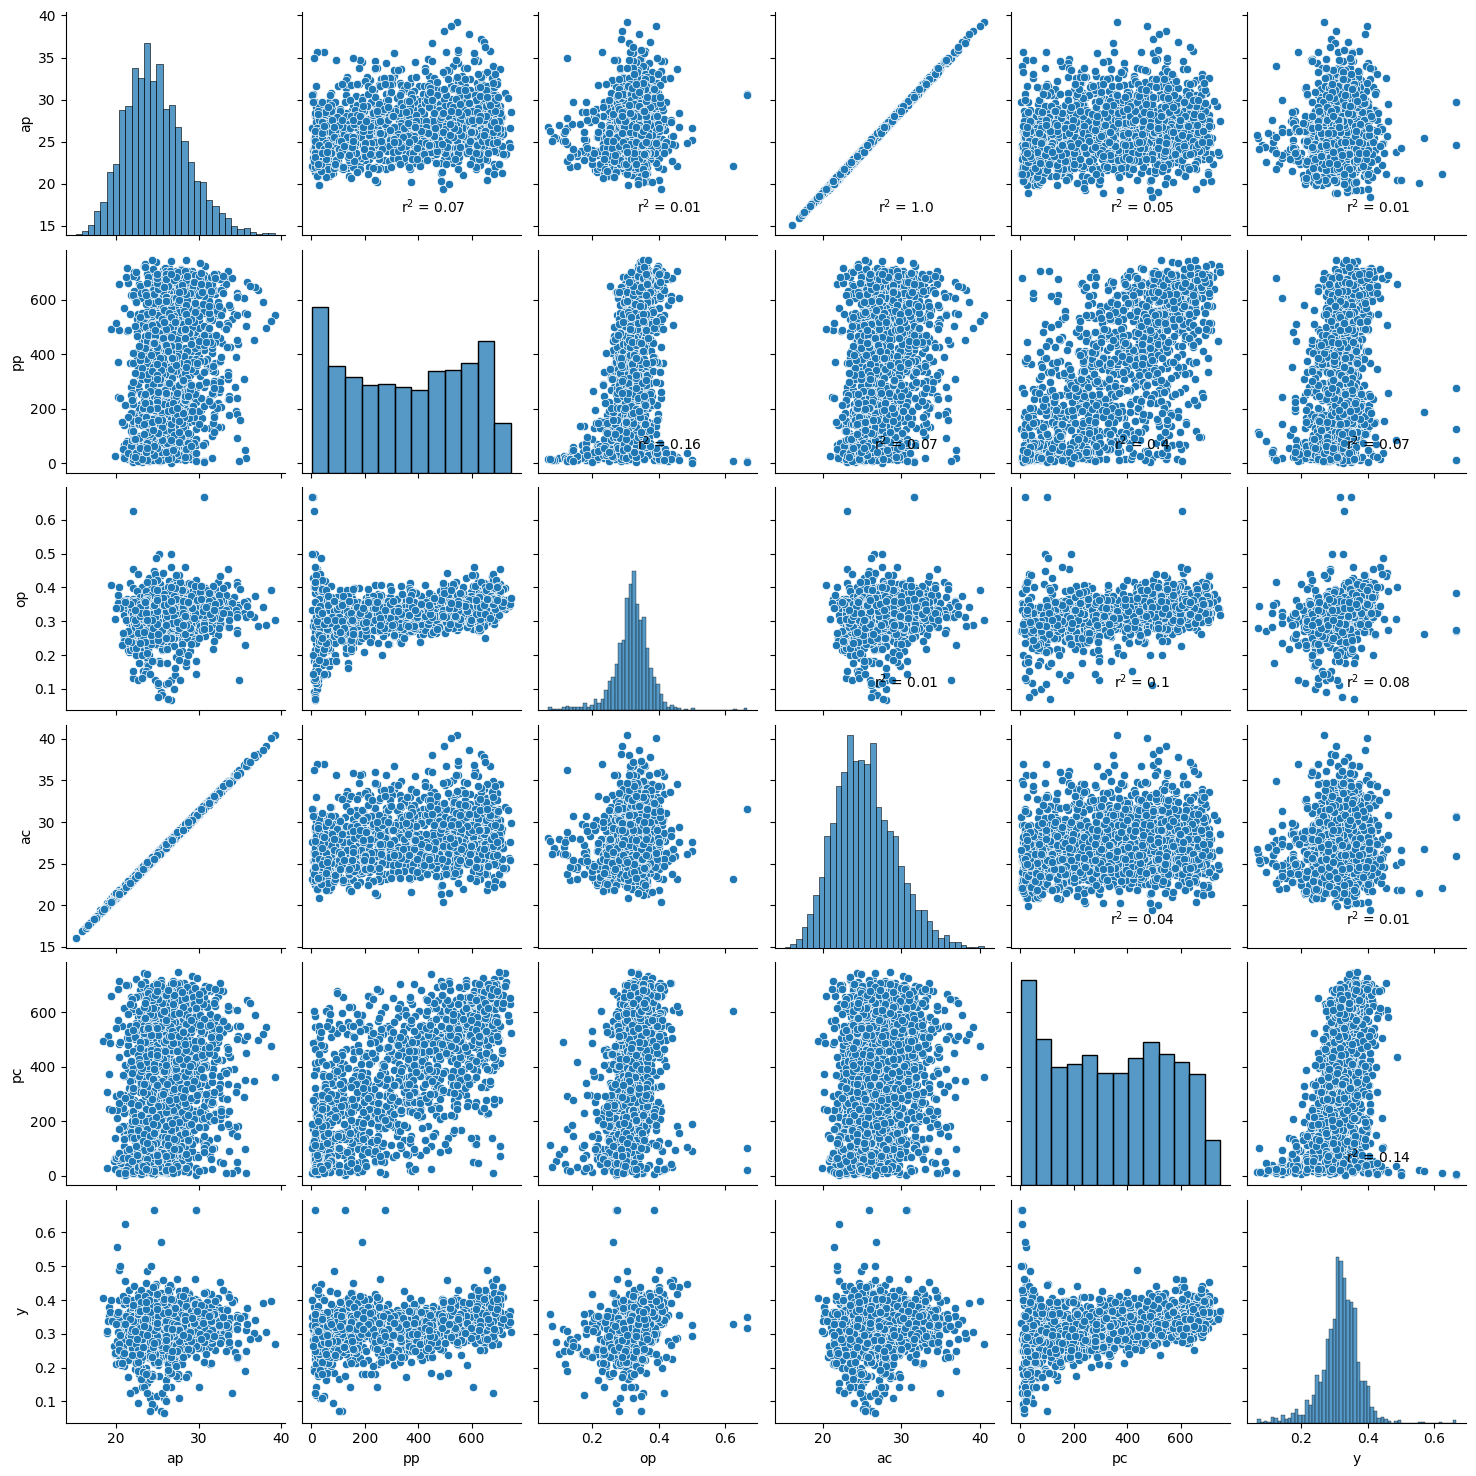

In [9]:
# Lets look at the pairwise relationships betweel all variables in my dataset to inform my model formulation
corr_mat = Dscaledtrain.corr()
r_squared = corr_mat ** 2
g = sns.pairplot( Dscaledtrain, kind='scatter', diag_kind='hist' ) # Looking at the scaled values because 2020 
for i, j in zip(*plt.np.triu_indices_from(g.axes, 1)):
    r2_val = r_squared.iloc[i, j].round(2)
    g.axes[i, j].annotate(f"r$^2$ = {r2_val}", (0.6, 0.1), xycoords='axes fraction', ha='center', fontsize=10 )
plt.show()

#### Observations from corr plots:
- Age of Prior Year (ap):
    - Obvious and of-course, predictably perfect relationship with age of current year (ac).
    - Very weak but visually apparanet relationship (r2=0.07, r2=0.05) to prior and current year plate appearances, respectively. 
    - Nonzero, but effectively zero, relationships with OBP for prior and current years.
- Age of Current Year (ac):
    - Same.
- Plate appearances of prior year (pp):
    - Modest relationship (0.17) to OBP prior year (op).
    - Strong relationship (0.4) to plate appareances in current year (pc).
    - Weak relationship (0.07) to OBP current year (y)
- Plate appearances current year (pc):
    - Strong relationship (0.4) to plate appareances in prior year (pp). 
- OBP prior year (op):
    - Modest relationship (0.17) to pp.
    - Mild relationship (0.1) to plate appearnaces current year (pc).
    - Weak relationship (0.08) to y.
- OBP current year (y);:
    - Modest relationship (0.14) to plate appearnaces current year (pc)
    - Weak relationships (0.08, 0.07) to op and pp, respectively.
    - near zero relationships to ap and ac.

##### Plan:
To predict OBP using only this data, we need plate appearances of the current year, OBP prior year, and plate appearances of prior year. 
For now, let's assume that we are predicing OBP given some given input for pc. Lets make a model that predicts OBP for those inputs. Then maybe later we can make a separte model that predicts Pc and uses that as one of the inputs for predicting oc. May need to toy around with the 


---------------------------------------------------
# 1. Model Buidling - Bayesian Regression Model for Predicting PA
#### Rationale:
- Create a model for predicting PA because we cannot use the 2021 PA data for our predictions.
    - The only real strong predictor (within this data) for PA is the prior year's PA.
    - To start, my model for PA will only have this one predictor.
        - Given my prior knowledge about baseball, I'll set a the prior distribution for PA_prior (aka 'pp') to be a Normal distribution with mean (mu) of 450 and sigma of 125 because that gave a confidence interval of [163,638], which are typical expected values in baseball.
        - Post-edit: After failing to produce a model many times, I opted to remove the y-intercept specification from the model because it previously estimated the intercept value way too high (>150,000). I don't understand why this happens at all. Regardless, the predicted values are off by several orders of magnitude.

In [ ]:
# scale the data to avoid numerical instability -- post-edit: this was unused. Leavign it here for reference.
from sklearn.preprocessing import StandardScaler

# define the scaler
def scale_data( df ):
    df2 = df.copy()
    scaler = StandardScaler()
    num_cols = df2.select_dtypes( include=['float64', 'int64'] ).columns
    df2[num_cols] = scaler.fit_transform( df2[num_cols] )
    return df

Dtrain_scaled = scale_data( Dtrain )
Dtest_scaled = scale_data( Dtest )
print( Dtrain_scaled.head )

<bound method NDFrame.head of         ap     pp     op    ac     pc      y
1903  23.4    NaN    NaN  24.4  332.0  0.307
2097  22.8  149.0  0.255  23.8  197.0  0.355
926   26.2  124.0  0.306  27.1  161.0  0.398
2077  20.8    NaN    NaN  21.8    NaN    NaN
464   20.6    NaN    NaN  21.6    NaN    NaN
...    ...    ...    ...   ...    ...    ...
1965  20.3    NaN    NaN  21.3    NaN    NaN
1314   NaN    NaN    NaN  23.1    NaN    NaN
1356   NaN    NaN    NaN  23.3    NaN    NaN
1552  28.7  247.0  0.356  30.0   59.0  0.254
1032   NaN    NaN    NaN  21.8  118.0  0.359

[2860 rows x 6 columns]>


Automatically removing 1592/2860 rows from the dataset.
Sampling: [Intercept, pp, y_sigma]


# total:	 1268
# burn-in:	 126
# draw:		 1141


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 4 chains for 10 tune and 1_141 draw iterations (40 + 4_564 draws total) took 134 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 4564 divergences after tuning. Increase `target_accept` or reparameterize.


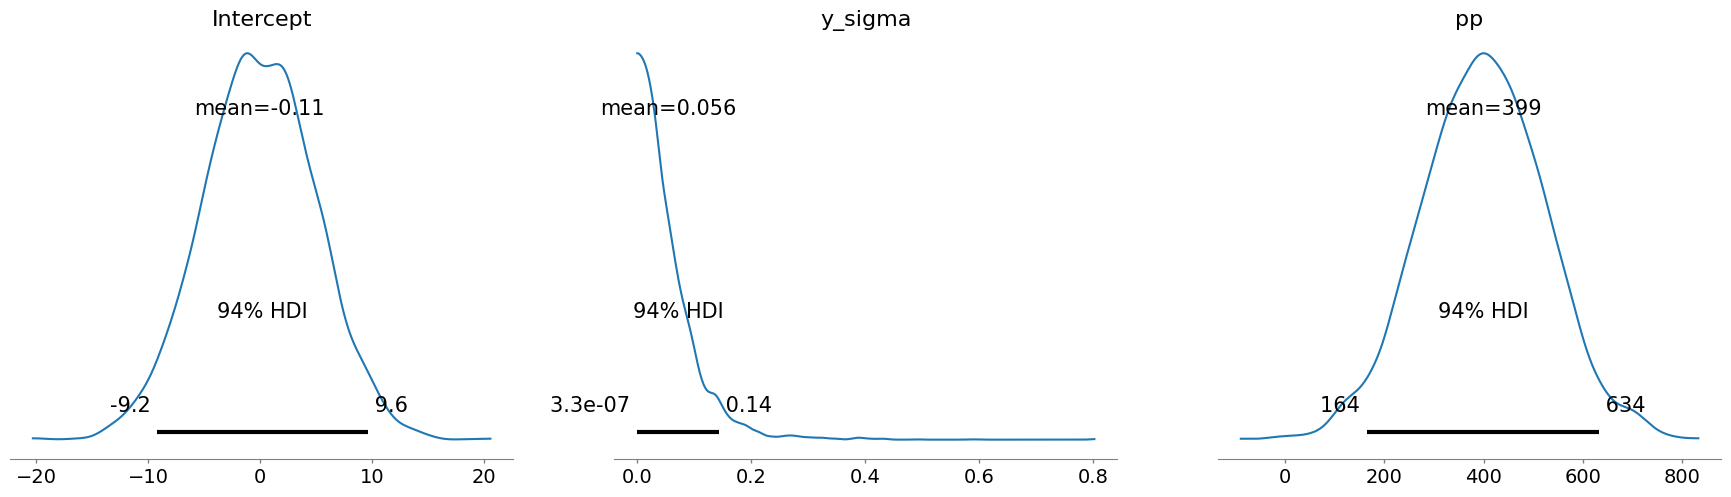

In [89]:
# Define a model for predicting current year plate appearances (pc) given prior year's plate appearances
pc_priors = { 'Intercept' : bmb.Prior( 'Normal', mu=0, sigma=5 ),
            'pp' : bmb.Prior( 'Normal', mu=400, sigma=125 )
}

# I think current pa is a function of prior years' plate appearances (pp)
basic_PA_model = bmb.Model( 'y ~ pp', data=Dtrain, priors=pc_priors, dropna=True )
basic_PA_model.build()
basic_PA_model.plot_priors()

# Computer burn-in (hard-coding this because the dropna=True causes a print-out that says: "Automatically removing 1592/2860 rows from the dataset.")
num_remaining_datapoints = 2860-1592
percent_burn = 0.10 # Typically 10-30% but this is hardcoded to figure out how min samples required to prevent RuntimeWarnings of numerical overflow
num_burn_in = int( np.floor( percent_burn * num_remaining_datapoints ) ) 
num_draw = int( np.floor( (1 - percent_burn) * num_remaining_datapoints ) )
print( '# total:\t', num_remaining_datapoints )
print( '# burn-in:\t', num_burn_in )
print( '# draw:\t\t', num_draw )

# Fit model 
basicPA_results = basic_PA_model.fit( method='mcmc', draws=num_draw, tune=10,
                chains=4, target_accept=0.8, progressbar=True,
                cores=1 ) # need cores==1 to avoid a "cannot pickle fortran object" error: https://discourse.pymc.io/t/an-error-message-about-cant-pickle-fortran-objects/1073/11

<xarray.Dataset>
Dimensions:    (chain: 4, draw: 1141, y_obs: 1268)
Coordinates:
  * chain      (chain) int32 0 1 2 3
  * draw       (draw) int32 0 1 2 3 4 5 6 ... 1134 1135 1136 1137 1138 1139 1140
  * y_obs      (y_obs) int32 0 1 2 3 4 5 6 ... 1262 1263 1264 1265 1266 1267
Data variables:
    Intercept  (chain, draw) float64 -1.447e+05 -1.447e+05 ... -1.445e+05
    pp         (chain, draw) float64 399.6 399.6 399.6 ... 399.1 399.1 399.1
    y_sigma    (chain, draw) float64 0.08074 0.08074 0.08074 ... 1.355 1.355
    y_mean     (chain, draw, y_obs) float64 -8.515e+04 -9.514e+04 ... -4.593e+04
Attributes:
    created_at:                  2023-05-08T19:55:58.829452
    arviz_version:               0.15.1
    inference_library:           pymc
    inference_library_version:   5.3.1
    sampling_time:               134.36916708946228
    tuning_steps:                10
    modeling_interface:          bambi
    modeling_interface_version:  0.10.0
0.5579896702729166


c:\Users\urp6gg\OneDrive - University of Virginia\Phillies-DS_Questionnaire\.bambi_venv\lib\site-packages\arviz\stats\density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
c:\Users\urp6gg\OneDrive - University of Virginia\Phillies-DS_Questionnaire\.bambi_venv\lib\site-packages\arviz\stats\density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


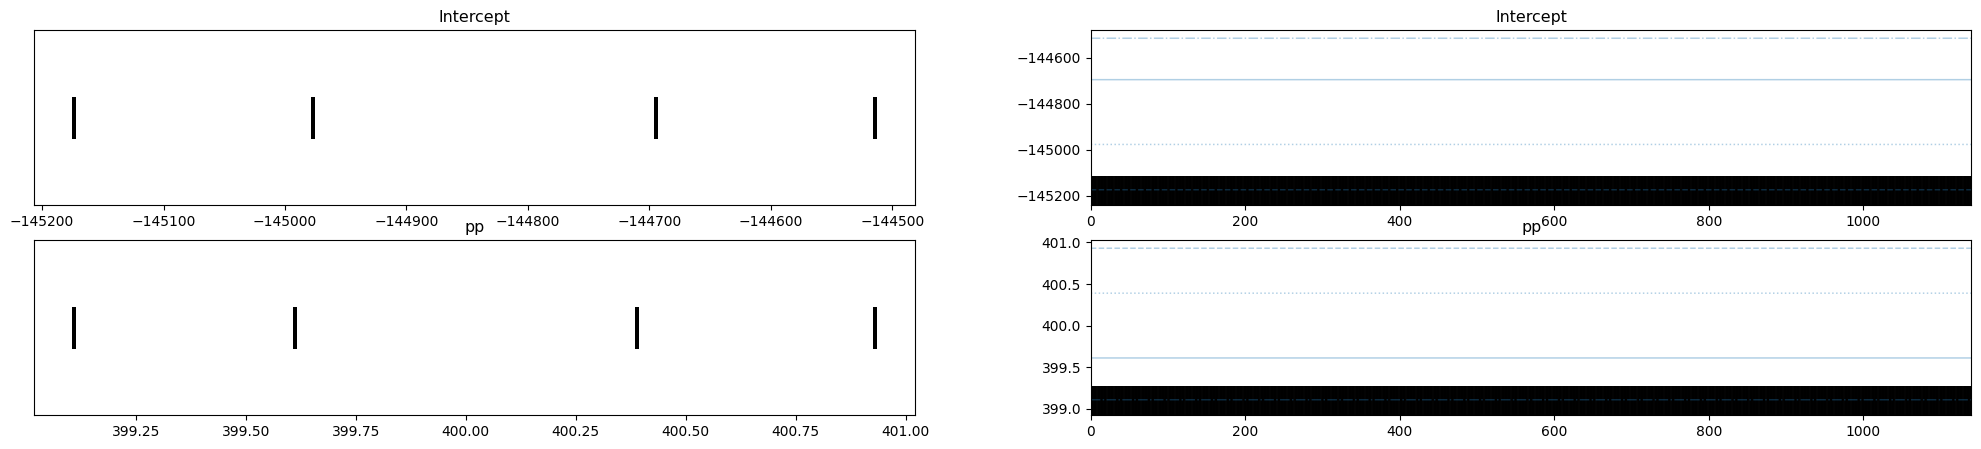

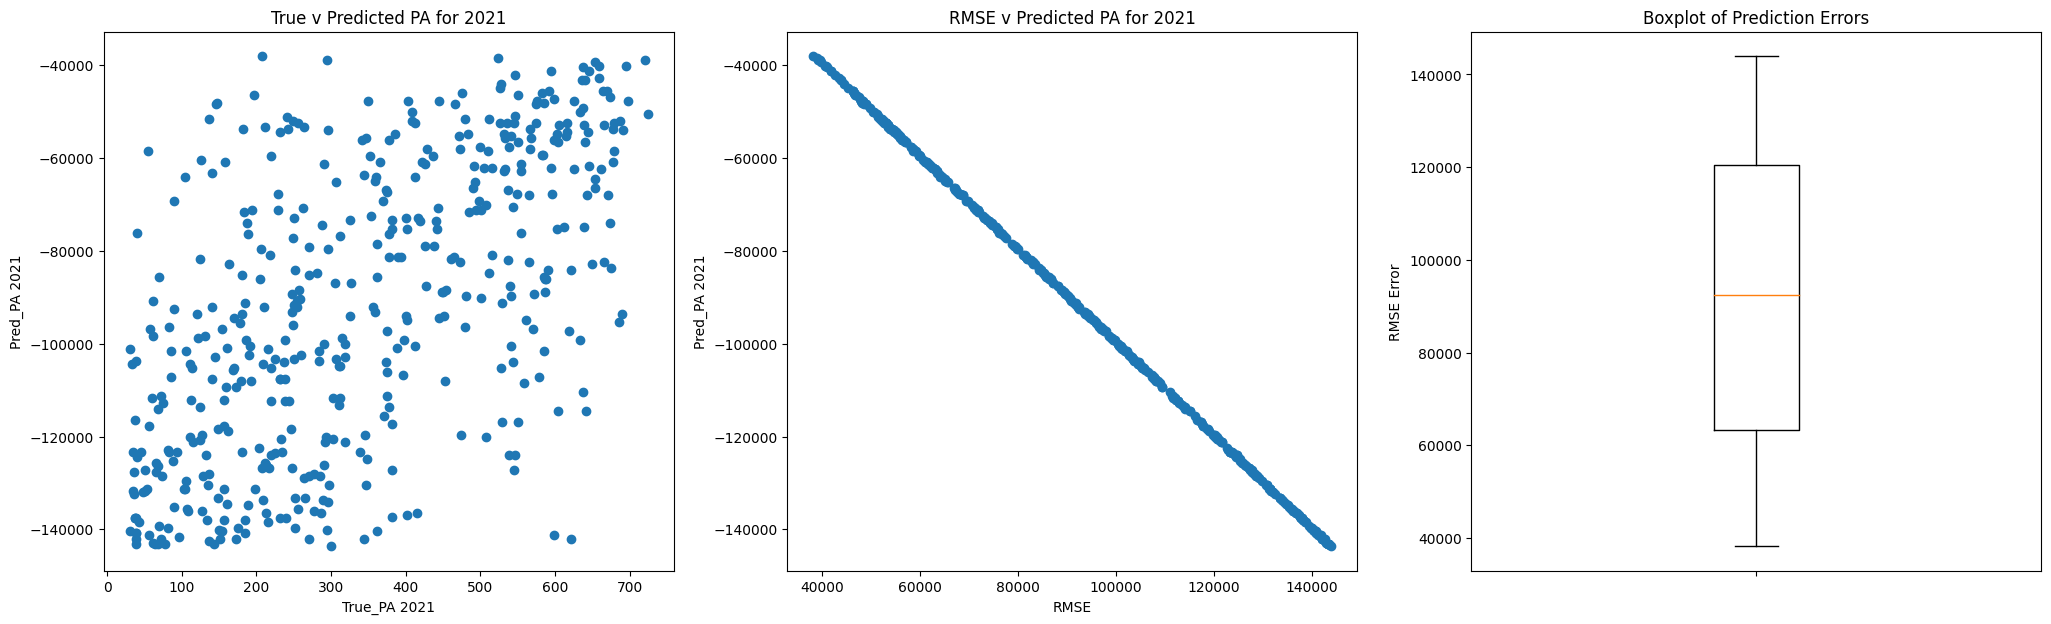

In [91]:
# Analyze PA model results
# Computer posterior distribution
basicPA_posterior = basicPA_results.posterior
basicPA_posterior_predictive = basic_PA_model.predict( basicPA_results, kind="pps" )
print( basicPA_posterior  )

# trace plots, autocorrelation, model summary, posterior plot
az.plot_trace( basicPA_results, var_names=['Intercept', 'pp'], figsize=(25,5) )
# az.plot_autocorr( basicPA_results, figsize( 25,5 ) )
# az.summary( basicPA_results )
# az.plot_ppc( basicPA_results, figsize( 25,5 ) ) 

# Predict the 2021 data.
pred2021 = { 'pc_pred' : [], 'lb': [], 'ub': [], 'pc_true' : [], 'RMSE' : [], 'prcnt_diff' : [] }

y_sigma = basicPA_posterior.y_sigma.values.mean()
intcpt = basicPA_posterior.Intercept.values.mean()
beta_pp = basicPA_posterior.pp.values.mean()
print( y_sigma )
for row_i in range( len( Dtest ) ):
    pa_p = Dtest.iloc[row_i]['pp']
    pa_c = Dtest.iloc[row_i]['pc']
    if np.isnan( pa_p ):
        continue
    y_pred = intcpt + beta_pp*pa_p
    pred2021['pc_pred'].append( y_pred )
    pred2021['lb'].append( y_pred - 1.96 * y_sigma )
    pred2021['ub'].append( y_pred + 1.96 * y_sigma )
    pred2021['RMSE'].append( np.sqrt( np.nanmean( pa_c - y_pred ) ** 2 ) )
    pred2021['prcnt_diff'].append( np.abs( pa_c - y_pred ) / ( ( pa_c + y_pred ) /  2) )
    pred2021['pc_true'].append( pa_c )

# print( pred2021['RMSE'])

# Plot RMSE and predictions v true
fig, axs = plt.subplots( nrows=1, ncols=3, figsize=(25,7) )
axs[0].scatter( pred2021['pc_true'], pred2021['pc_pred'] )
axs[0].set_xlabel( 'True_PA 2021')
axs[0].set_ylabel( 'Pred_PA 2021' )
axs[0].set_title( 'True v Predicted PA for 2021')
axs[1].scatter( pred2021['RMSE'], pred2021['pc_pred'] )
axs[1].set_xlabel( 'RMSE')
axs[1].set_ylabel( 'Pred_PA 2021' )
axs[1].set_title( 'RMSE v Predicted PA for 2021')
axs[2].boxplot( pred2021['RMSE'] )
axs[2].set_ylabel('RMSE Error')
axs[2].set_xticklabels([''])
axs[2].set_title('Boxplot of Prediction Errors')
plt.show()

#### Discussing results for PA prediction model:
- Well, this was a failure. I've ran out of time to complete this assignment but I know that my next move would be to look into why the scale for the predictions is so large (1000x) and also negative.
    - It is interesting that the trend between true and predicted PA values is linear, though, i.e., increasing values for the True_PA of 2021 correspond to increasing values in the prediction. That is the correct trend.
    - Looking at the drawn values for the Intercept in the output above these plots, we can see that the values for Intercept are definitely the source of the error. I would retrain this if I had time to bound intercept values to something more realistic for the scale of Plate Appearances, e.g., [-50, 50]
    - It's not obvious to me how to use the traceplots to debug this. Nore is the RMSE v Predicted plot.
- I will not use predicted values of PA for my model that predict. Instead, I will evaluate that model's accuracy with inputs for PA that is an average of 2016-2019 values for each position player.

---------------------------------------------------
# 2. Model Buidling - Bayesian Regression Model for Predicting On-Base Percentage (OBP)
#### Rationale:
- Create a model for predicting OBP
    - The only real strong predictor (within this data) for OBP is the prior year's OBP (op), the prior year's PA (pp), and the current year's plate appearances PA (pc).
    - To start, my model will only use a linear equation for these three variables as predictors. 
        - Model formulation: OBP_current_year ~ intercept + beta_1 x OBP_prior_year + beta_2 x PA_prior_year + beta_3 x PA_current_year
    - Prior distributions for my inputs:
        - Intercept is given a normal prior distribution centered at mean (mu) of 0 and a sigma of 50. Sigma is relatively large compared to expected OBP values because I am very uncertain about the impact of an Intercept on my predictive equation.
        - OBP_prior_year is given a Beta prior distribution because that distribution falls betwee 0.0 and 1.0, like OBP. I set my mean value as a guess of 0.3, which is a decent OBP in baseball. My 'nu' parameter is 100 because I am pretty confident and the resulting prior distribution gives a 95% credible set ranginge from around [200,500], which is totally reasonable for baseball.
        - PA_prior_year is given a Gamma prior distribution because it is always positive but not bounded to [0.0, 1.0] like Beta distributions. I set my mu to 450 and my sigma to 50 because I'm medium confident.
        - PA_current_year is also given a Gamma prior distribution for the same reason. I gave it a marginally larger mean because people in this dataset tend to get more plate appearances with age, albeit only by a little.


Automatically removing 1592/2860 rows from the dataset.
Sampling: [Intercept, op, pc, pp, y_sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Sampling 4 chains for 1_258 tune and 1_141 draw iterations (5_032 + 4_564 draws total) took 1579 seconds.


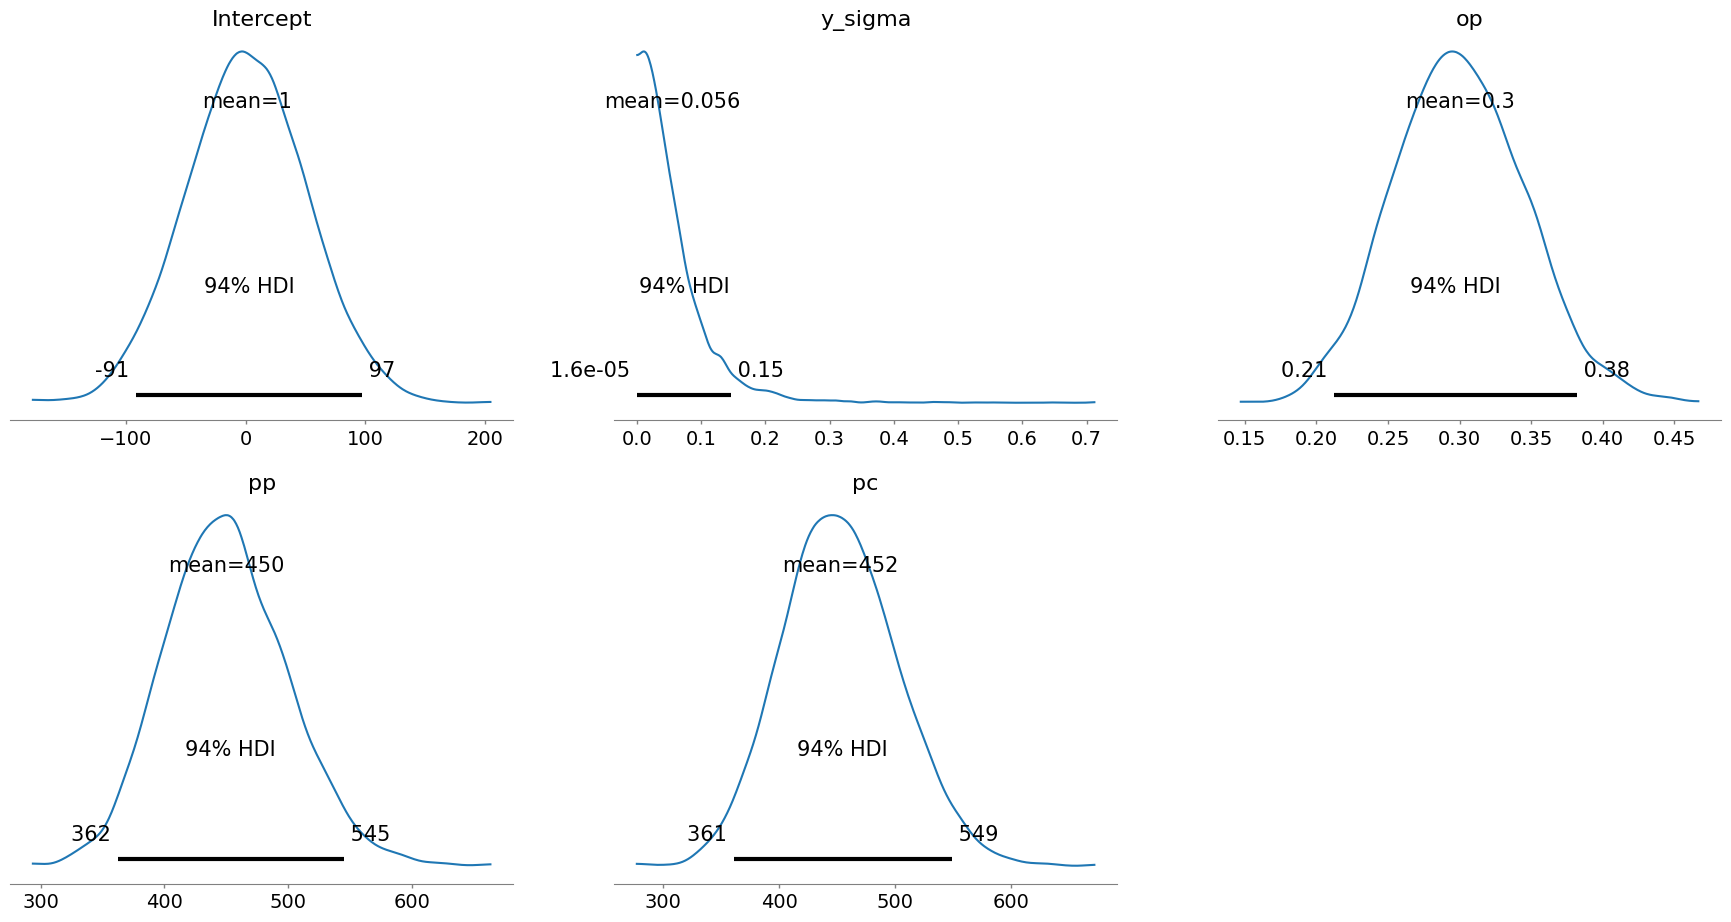

In [64]:
# Define model that predict obps of current year given only prior year's obp.
my_priors = { 'Intercept' : bmb.Prior( 'Normal', mu=0, sigma=50 ),
            'op' : bmb.Prior( 'Beta', mu=0.3, nu=100 ),
            # 'ap' : bmb.Prior( 'Normal', mu=30, sigma=7 ), 
            # 'ac' : bmb.Prior( 'Normal', mu=30.1, sigma=6.9 ),
            'pc' : bmb.Prior( 'Gamma', mu=451, sigma=50 ),
            'pp' : bmb.Prior( 'Gamma', mu=450, sigma=50 )
}

# I think current obp is a function of prior years' obp (op), plate appearances for prior year (pp), and plate appearances for current year (pc).
basic_OBP_model = bmb.Model( 'y ~ op + pp + pc', data=Dtrain, priors=my_priors, dropna=True )
basic_OBP_model.build()
basic_OBP_model.plot_priors()

# Fit model 
basic_OBP_results = basic_OBP_model.fit( method='mcmc', draws=num_draw, tune=1268-10, chains=4, target_accept=0.9, progressbar=True, cores=1 )

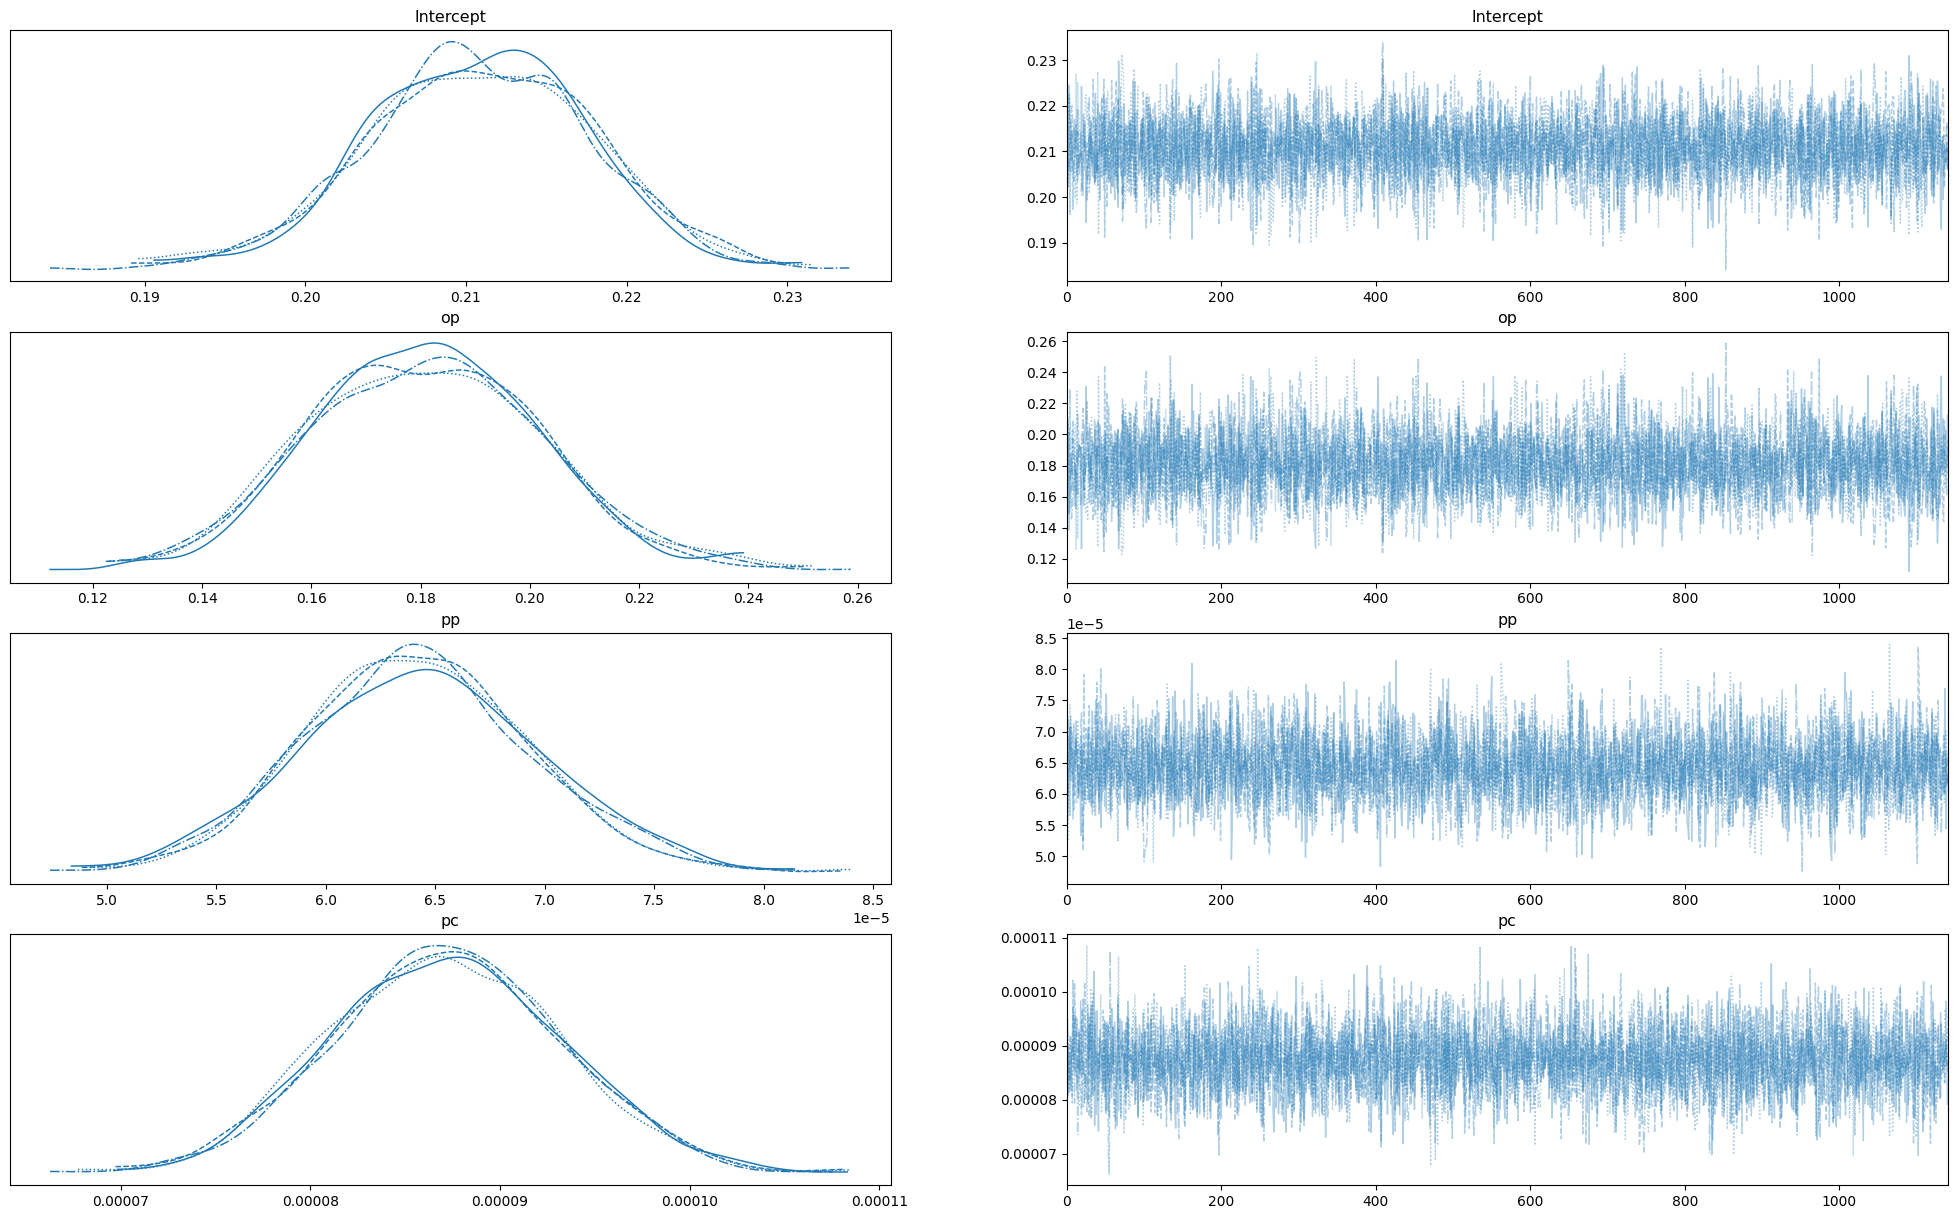

c:\Users\urp6gg\OneDrive - University of Virginia\Phillies-DS_Questionnaire\.bambi_venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


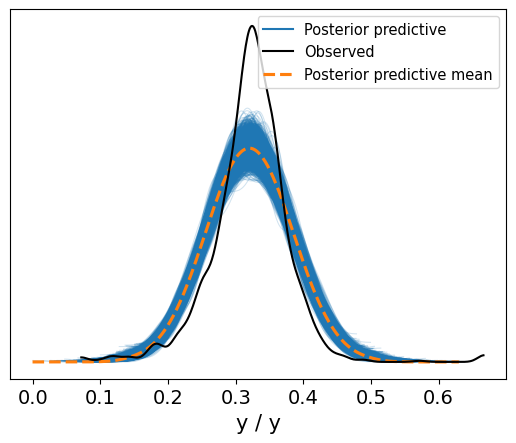

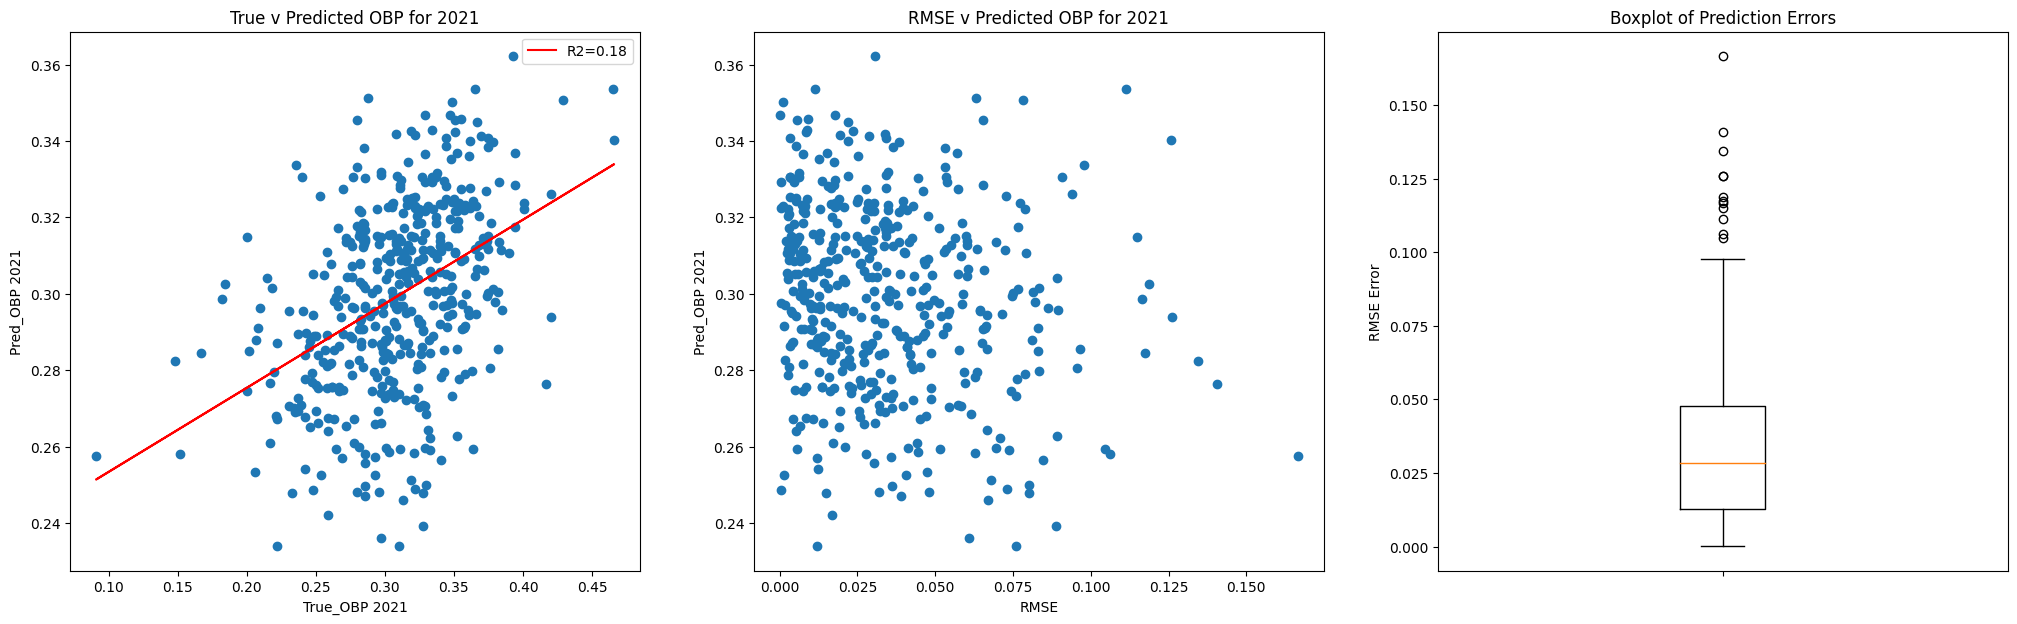

In [177]:
# Computer posterior distribution
basic_OBP_results_samples = basic_OBP_results.posterior
basic_OBP_posterior_predictive = basic_OBP_model.predict( basic_OBP_results, kind="pps" )

# trace plots, autocorrelation, model summary, posterior plot
az.plot_trace( basic_OBP_results, var_names=['Intercept', 'op', 'pp', 'pc'], figsize=(25,15) )
# az.plot_autocorr( basic_OBP_results )
az.summary( basic_OBP_results )
az.plot_ppc( basic_OBP_results ) 

# Predict given the 2021 data.
obp2020 = Dtrain['op']
age2021 = Dtest['ac']
pred2021 = { 'obp_pred' : [], 'lb': [], 'ub': [], 'obp_true' : [], 'RMSE' : [], 'prcnt_diff' : [] }
simple_mean_PA = np.round( Dtrain[['pp','pc']].mean().mean(), 0 )

y_sigma = basic_OBP_results.posterior.y_sigma.values.mean()
intcpt = basic_OBP_results.posterior.Intercept.values.mean()
beta_pp = basic_OBP_results.posterior.pp.values.mean()
beta_pc = basic_OBP_results.posterior.pc.values.mean()
beta_op = basic_OBP_results.posterior.op.values.mean()
for row_i in range( len( Dtest ) ):
    obp_prior = Dtest.iloc[row_i]['op']
    obp_now = Dtest.iloc[row_i]['y']
    pa_prior = Dtest.iloc[row_i]['pp']
    # pa_now = Dtest.iloc[row_i]['pc'] # Can't use 2021 PA data to make prdictions about 2021 OBP
    pa_now = Dtest.iloc[row_i]['PA_avg']
    
    #  # this should be output from a PA_model but that thing did not work so I am going to use average of 2016-2019 isntead.
    if np.isnan( obp_prior ) or np.isnan( obp_now ) or np.isnan( pa_prior ) or np.isnan( pa_now ):
        continue
    y_pred = intcpt + beta_op*obp_prior + beta_pc*pa_now + beta_pp*pa_prior

    pred2021['obp_pred'].append( y_pred )
    pred2021['lb'].append( y_pred - 1.96 * y_sigma )
    pred2021['ub'].append( y_pred + 1.96 * y_sigma )
    pred2021['RMSE'].append( np.sqrt( np.nanmean( y_pred - obp_now ) ** 2 ) )
    pred2021['prcnt_diff'].append( np.abs( obp_now - y_pred ) / ( ( obp_now + y_pred ) /  2) )
    pred2021['obp_true'].append( obp_now )

# print( pred2021['RMSE'])

m, b = np.polyfit( pred2021['obp_true'], pred2021['obp_pred'], 1)

# Plot RMSE and predictions v true
fig, axs = plt.subplots( nrows=1, ncols=3, figsize=(25,7) )
axs[0].scatter( pred2021['obp_true'], pred2021['obp_pred'] )
axs[0].plot( pred2021['obp_true'], np.multiply( m, pred2021['obp_true'] ) + b, color='red', label="R2="+str( np.round( np.corrcoef( pred2021['obp_true'], pred2021['obp_pred'] )[0, 1] ** 2, 2 ) ) )
axs[0].legend()
axs[0].set_xlabel( 'True_OBP 2021')
axs[0].set_ylabel( 'Pred_OBP 2021' )
axs[0].set_title( 'True v Predicted OBP for 2021')
axs[1].scatter( pred2021['RMSE'], pred2021['obp_pred'] )
axs[1].set_xlabel( 'RMSE')
axs[1].set_ylabel( 'Pred_OBP 2021' )
axs[1].set_title( 'RMSE v Predicted OBP for 2021')
axs[2].boxplot( pred2021['RMSE'] )
axs[2].set_ylabel('RMSE Error')
axs[2].set_xticklabels([''])
axs[2].set_title('Boxplot of Prediction Errors')
plt.show()

# 4. Discussion of OBP Prediction Model's Results.

#### Preamble:
This is a fascinating problem and I spent far more than "a few hours" on this (as the invite recommended). I played around with many models, each of which taking 10-30 minutes to train. I haven't used Bayesian models since 2020, so I was a bit rusty and I spent a lot of time refamiliarizing and debugging. Furthermore, the problem scope was compelling -- predict OBP given only birthdate and prior year's OBP and PA? There were so many thread to follow. I spent a great deal of time exploring how to incorporate age into my data before finally accepting that i didn't have enough time. I maintain that personal performance curves, as defined by OBP, should follow some arc according to age such that OBP tends to be best for people in their prime. If I had more time I would look into interaction terms between age and prior year OBP.


#### Motivation for Bayesian.
Predicting is a function of both individual experience/skill and general trends of piers. This means that technical proficiency as measured by OBP is sensative to both prior individual data and the distribution of a broader population. I choose to use Bayesian regression for this reason. That I posses some subject matter understanding of baseball is additional motivation because I can use that information to inform subjective prior distributions for my model.

#### OBP model Result.
Defining my model as y ~ op + pp + pc -- where y is current OBP, op is prior year OBP, pp is prior year PA, and pc is current year PA -- resulting in a successful convergence of all 4 chains in the markov chain monte carlo sampling procedure. The traceplots show concordantly sampled distributions for op, pp, pc, and the intercept, indicating that the model converges on the posteriod distributions regardless of the starting point. The plot below the traceplots shows the posteriod distribution as compared to the observed 2021 data. The mean values are vary similar, with my model just sightly under approximating the mean. The variance in my posterior distribution fared worse, and as a result, my distribution does not exactly match the observed data. 

I tested my model in the figures below, using each player's average PA values for 2016-2019 to serve as a proxy prediction for their 2021 PA (recall: my PA predictive model was not usable). I plugged those predicted PA values into my OBP model formulation, given the pp and op values from 2020. Three resulting plots show that (1, left) the predicted OBP values follow a diretly proportional trend and similar value range as the true OBP values; (2, center) the root-mean-squared error (RMSE: defined with respect to the the predicted OBP values versus the true OBP values) do not follow any trend with respect to the predicted values, i.e., my model does not bias toward higher or lower predicted OBP values; and (3) a boxplot showing the median, quartiles, and outlier values for my RMSE. I chose RMSE because it characterizes my model's error on the same scale as OBP. Overall, the RMSE values suggest that the model is decently accurate, with a median RMSE of 0.27 and an overall R2=0.18. While some of the outlier predictions bias this R2 downward, the result is remarkable given the parsimony of the model.

#### Limitations
Although there is code that preliminary investigated scaling the 2020 data, this model ultimately did not use it. In fact, the unscaled PA data from 2020 possibly contributed greatly to the error in the model. This is one of the primary limitations, in addition to the aforementioned issues in modeling PA. Furthermore, slightly more than half of the data points were ignored by the model because of the presence of NaNs. These NaN values correspond to missed seasons and/or incomplete data. Given that only 5 seasons worth of data were provided for training, the true number of effective training data for individuals is likely closer to 3. This severaly limited an already limited dataset composed of only about 500 players.

#### Future work
For future iterations of this model to be useful for actual OBP prediction, more data and more robust model specification are needed. Information that could be useful includes: player defensive position (certain positions tend to hit differently, for a variety of reasons), position in batting order, constituent OBP metrics like base on balls v extra base hits, SLG, and other more advanced metrics relating to getting on base. The additional data will almost certainly improve the model, as might intuitive interaction terms like base on balls to strikeouts -- people who walk tend to have a good eye and make better contact, thus resulting in greater OBP. Lastly, the abberation season of 2020 has profound ffects on this temporal data. There should be a wayu to scale offensive production and plate appearances accordingly because no individual seaason should be compared against 2020, save for the 1994 strike season.